# Stabilized ICA for transcriptomic data   

In this jupyter notebook, we propose a short example for the use of our stabilized ICA algorithm. We study the extraction of ICA components for a transcriptomic data set gathering NSCLC patients.   

**Note :** To run this jupyter notebook, you first need to extract the data set "data.csv" from the zip file "data.zip" (same directory)

In [1]:
%load_ext autoreload
%autoreload 2

# Setup for local running - please delete this block
import sys
sys.path.append('C:\\Users\\ncaptier\\Documents\\GitHub\\stabilized-ica')
sys.path.append('C:\\Users\\ncaptier\\Documents\\GitHub\\sica-omics')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

## 0. Load the data set

This data set was extraced from ["Defining the Biological Basis of Radiomic Phenotypes in Lung Cancer" Grossman et al. 2017](https://elifesciences.org/articles/23421).   
It contains the expression of 21,766 unique genes for 269 patients with Non-small cell lung cancer (NSCLC) treated at the H. Lee Moffitt Cancer Center, Tampa, Florida, USA. Gene expression values were measured on a custom Rosetta/Merck Affymetrix 2.0 microarray chipset and normalized with the robust multi-array average (RMA) algorithm.

In [3]:
df = pd.read_csv("data/data.csv" , index_col=0)
df.head()

,3643,84263,7171,2934,11052,1241,6453,57541,9349,11165,...,643669,1572,8551,26784,26783,26782,26779,26778,26777,100132941
RadioGenomic-017,5.205151,7.097989,9.559617,8.396808,7.603719,7.990605,10.044401,9.054930,7.383169,8.177010,...,6.419273,3.809826,6.507880,6.572121,5.400848,5.951391,3.381860,9.825584,2.905091,5.622438
RadioGenomic-055,5.615738,6.585052,9.777869,9.082415,8.639498,6.781274,9.541826,8.866110,6.422702,7.196294,...,5.753828,4.186127,6.821582,7.031406,4.852417,6.140850,2.629760,9.005145,3.366466,5.495330
RadioGenomic-227,5.679276,7.747854,10.648704,9.127985,7.369421,7.203773,8.972255,8.328371,7.269232,7.449183,...,5.666999,4.316130,6.637855,6.248824,4.664228,5.767970,2.911470,8.674466,3.337194,6.308605
RadioGenomic-222,5.317341,7.196276,10.949771,8.098896,7.639882,7.971876,10.159637,8.667702,8.474250,7.271477,...,5.531060,3.403776,7.059419,6.201873,4.690005,6.256286,4.119688,9.099659,3.181781,5.740033
RadioGenomic-212,7.196904,9.346492,9.673778,9.358636,8.741693,7.616498,10.376653,8.701461,6.601991,7.344651,...,5.519642,3.796049,7.332635,6.050121,4.898523,6.537895,3.600895,8.792510,2.945391,5.835411


**Note :** in the following step, we center the expression of each gene (i.e the columns of the dataframe df). Indeed, we noticed that omitting this pre-processing step led to one ICA component entirely driven by the differences between the  mean expression of each gene. This component is not biologically relevant and we avoid it thanks to this centering step.

In [4]:
X = df.apply(func = lambda x : x - x.mean() , axis = 0)

## 1. Most Stable Transcriptome Dimension (MSTD)   

In order to select the number of ICA components we refer to ["Determining the optimal number of independent components for reproducible transcriptomic data analysis" Kairov et al. 2017](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-017-4112-9). The idea is to find a trade-off between a sufficiently large number of components to capture all essential information and a restricted dimension to avoid ending up with a lot of very unstable components which only capture noise.   

To do so we plot the stability distribution for a wide range of different number of components M = 5, ... , 100 and we observe which choice of M most satisfies the trade-off.

  0%|          | 0/49 [00:00<?, ?it/s]

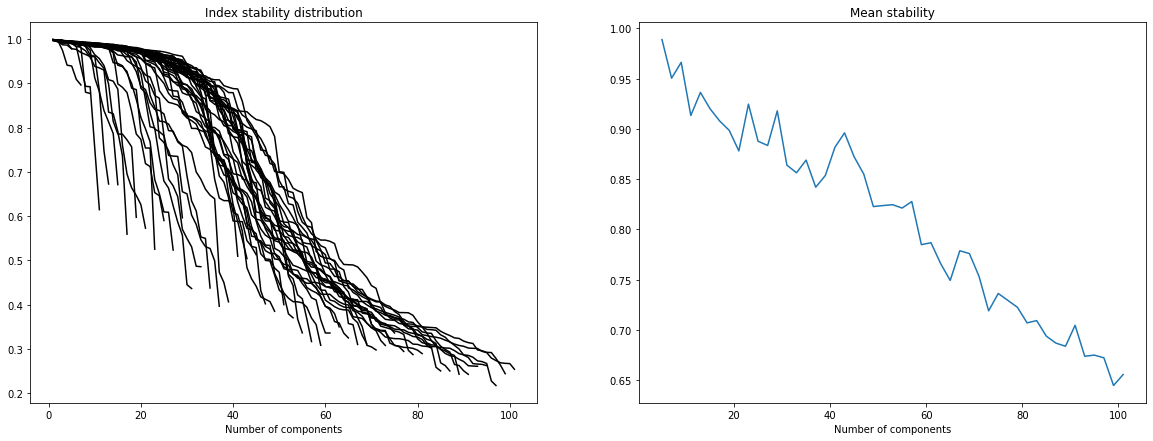

In [4]:
from sica.base import MSTD
MSTD(X.values , m = 5 , M = 100 , step = 2 , n_runs = 20)

Please note that in the following we use a rough estimation of the optimal dimension (observed thanks to the graphs above). In fact more sophisticated techniques can be applied to estimate this dimension (ex: two-lines clustering) ; these can be found in the article cited above.

In [5]:
dim_opt = 45

## 2. Stabilized ICA and Multidimensional Scaling (MDS)   

This stabilized ICA algorithm is a copy of the ICASSO algorithm (implemented in MATLAB) (["ICASSO: software for investigating the reliability of ICA estimates by clustering and visualization" Himber et al.](https://www.cs.helsinki.fi/u/ahyvarin/papers/Himberg03.pd) The main idea is to iterate several times the FastICA algorithm (ex: from sklearn), cluster the results (agglomerative hierarchical clustering) and define the final ICA components as the centrotype of each cluster.   

Some explanation for Multidimensional Scaling can be found on the sklearn page : https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html 

In [6]:
from sica.base import StabilizedICA 

running time (min): 00:54.54


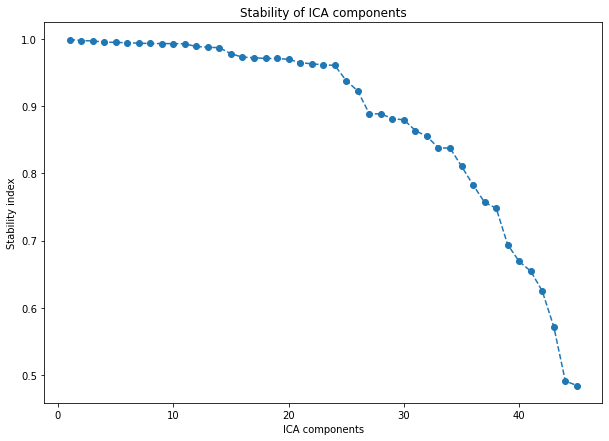

In [7]:
start = time.time()

sICA = StabilizedICA(n_components=dim_opt, n_runs=30, plot=True, n_jobs=-1)
sICA.fit(X)

end = time.time()

minutes, seconds = divmod(end - start, 60)
print("running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))

running time (min): 00:31.51


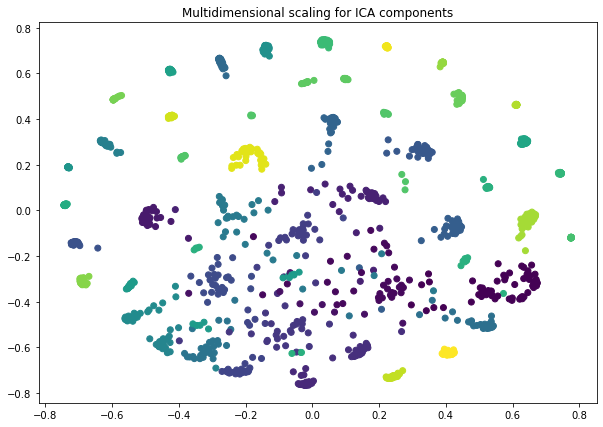

In [8]:
fig , ax = plt.subplots(figsize = (10 , 7))

start = time.time()

sICA.projection(ax = ax , method = 'mds')
ax.set_title("Multidimensional scaling for ICA components")

end = time.time() 

minutes, seconds = divmod(end - start, 60)
print("running time (min): " + "{:0>2}:{:05.2f}".format(int(minutes),seconds))

**Note :** by default, each stabilized ICA component (i.e a row of the S_ matrix) is normalized to unit variance and re-oriented towards positive heaviest tail. These operations facilitate the interpretation of the components and allow us to compare several components from different studies.

In [9]:
Metagenes = pd.DataFrame(sICA.S_ , columns = df.columns , index = ['metagene ' + str(i) for i in range(sICA.S_.shape[0])])
Metagenes.head()

,3643,84263,7171,2934,11052,1241,6453,57541,9349,11165,...,643669,1572,8551,26784,26783,26782,26779,26778,26777,100132941
metagene 0,-0.502359,0.063330,0.619226,-0.584321,-0.034392,-0.645843,0.018026,0.165158,-0.390837,0.026501,...,0.211179,-0.369237,-0.975147,-0.142125,0.339079,0.118280,-0.761259,-0.183313,-0.006010,-0.323200
metagene 1,0.481376,-0.085962,-0.126218,0.490215,0.242829,0.751853,0.465473,-0.415335,0.587996,0.014006,...,-0.362256,3.178655,-0.159200,-0.211356,-0.387652,-0.137837,-0.474530,0.204819,0.312316,-0.018258
metagene 2,-0.813705,-0.287146,0.135293,0.005913,1.361459,0.175264,-0.335616,-0.120486,-2.524144,0.933776,...,-0.640554,-0.777672,-0.313629,0.010074,0.255665,1.612827,0.519558,0.661906,0.016296,-0.335104
metagene 3,0.029950,0.171725,0.607405,1.403389,-0.513840,2.216392,3.532994,0.286914,-1.342845,1.290781,...,0.489110,0.356925,0.674017,-1.592262,-1.058137,0.383702,0.648317,-0.687954,-0.364239,-0.733333
metagene 4,1.338965,-0.540206,-0.242459,-1.213108,0.724185,4.785730,0.466036,-0.455820,-0.756496,-0.013456,...,0.950401,0.123224,0.326030,2.161343,0.678265,1.191926,1.467889,1.275098,0.168216,-0.796021


We can check that we do obtain sparse ICA components by plotting the distribution of "metagene 1" values (i.e the coefficients associated with "metagene 1" for each feature)

Text(0, 0.5, 'Frequency')

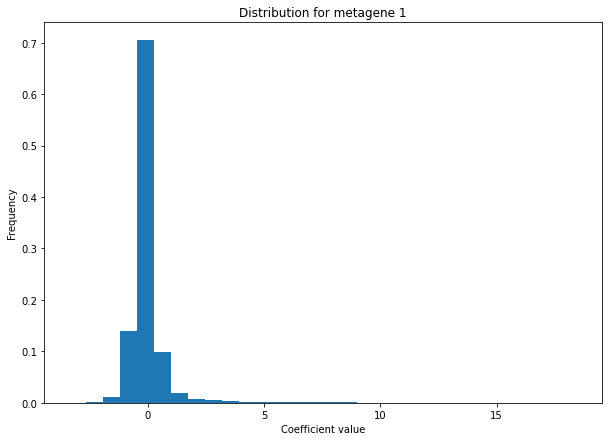

In [10]:
def distribution(Components ,  name , bins):  
    s = Components.loc[name]
    s.hist(bins = bins , weights=np.zeros_like(s) + 1. / s.size , grid = False)
    return

plt.figure(figsize = (10 , 7))
distribution(Metagenes , name = 'metagene 1' , bins = 30)
plt.title("Distribution for metagene 1")
plt.xlabel("Coefficient value")
plt.ylabel("Frequency")

## 3. Metagene annotation with sica-omics toolbox

Finally, we provide a complementary Python package, called sica-omics, which gathers specific tools for analyzing the results of stabilized-ica applied on omics data. In particular, it provides tools to perform enrichment analysis and characterize each metagene with relevant biological annotations. These tools gather two major operations : first, a list of the most expressed genes is retrieved for each metagene, and then an enrichment analysis is performed on this list using [reactome](https://reactome.org/) or [ToppFun](https://toppgene.cchmc.org/enrichment.jsp).  

A conversion tool (https://pypi.org/project/mygene/) is included in both methods. It can handle usual gene identifiers like Entrez gene ids, Ensemble gene ids, NCBI RefSeq ids, official gene symbols, HUGO Gene Nomenclature, UniProt ids, Affymetrix probeset ids, and a mix of everything. It automatically converts them to Entrez gene IDs. For ToppFun this conversion is necessary for the analysis to work.

### 3.1 Reactome enrichment analysis   

**Note :** This tool is based on the python package [reactome2py](https://pypi.org/project/reactome2py/).

In [11]:
from sicaomics.annotate import reactome

The user can choose different strategies for selecting the most expressed genes of each metagene :
- The user can choose to only look at the right tail of the metagene distribution, the left tail, both or the heaviest one.
- The user can choose whether the thresholds will be computed with deviations from the mean of the distribution (i.e $\mu \pm k*\sigma$) or with its quantiles.
- The user can fine tune these thresholds with the threshold parameter.

**Note :** Here we will set the parameter ``convert_ids`` to False since genes are already identified by Entrez gene ids and thus the conversion is not necessary.

In [12]:
Rannot = reactome.ReactomeAnalysis(data = Metagenes , threshold = 3 , method = 'std' , tail = 'heaviest' , convert_ids = False)

C:\Users\ncaptier\Documents\GitHub\sica-omics\sicaomics\annotate\reactome.py:77: UserWarning: If convert_ids is False ReactomeAnalysis will assume that the inputs are valid gene ids for Reactome analysis ((e.g HUGO gene symbols, EntrezGene , Uniprot ...). No conversion will be performed. See https://reactome.org/userguide/analysis for more details.
  warnings.warn(


**Note :** By default, an arbitrary threshold of 0.05 is used to filter Entities pValue. The user can change it with the p_value parameter. The user can also pass a list of species to filter the results as well as min and max thresholds for the number of entities per pathway.

In [13]:
Rannot.get_analysis(metagene = 'metagene 6' , species = 'Homo sapiens' , p_value=0.05).head(3)

,Pathway identifier,Pathway name,#Entities found,#Entities total,Entities ratio,Entities pValue,Entities FDR,#Reactions found,#Reactions total,Reactions ratio,Species identifier,Species name,Submitted entities found,Mapped entities,Found reaction identifiers
2,R-HSA-1474228,Degradation of the extracellular matrix,40.0,148.0,0.009799,0.0,0.0,87.0,105.0,0.007612,9606,Homo sapiens,50509;1284;1282;1281;176;1634;1513;80781;2006;...,,R-HSA-8940554;R-HSA-1602458;R-HSA-1474196;R-HS...
3,R-HSA-2022090,Assembly of collagen fibrils and other multime...,26.0,67.0,0.004436,0.0,0.0,21.0,26.0,0.001885,9606,Homo sapiens,50509;1284;1282;1281;80781;1278;1277;5118;7837...,,R-HSA-2395302;R-HSA-2022141;R-HSA-2299620;R-HS...
4,R-HSA-1442490,Collagen degradation,29.0,69.0,0.004568,0.0,0.0,27.0,34.0,0.002465,9606,Homo sapiens,50509;1284;1282;1281;1634;1513;80781;1278;1277...,,R-HSA-1564117;R-HSA-1474196;R-HSA-1474197;R-HS...


Finally, the complete analysis can be browsed and visualized in reactome web portal (you need an internet access for this function).

In [18]:
Rannot.open_full_analysis(metagene = 'metagene 6')

### 3.2 Toppfun enrichment analysis

In [14]:
from sicaomics.annotate import toppfun

**Note :** ToppFunAnalysis intializes the same way as ReactomeAnalysis. Please refer to the precedent section for some explanations.

In [15]:
Tannot = toppfun.ToppFunAnalysis(data = Metagenes , threshold = 3 , method = 'std' , tail = 'heaviest' , convert_ids = False)

C:\Users\ncaptier\Documents\GitHub\sica-omics\sicaomics\annotate\toppfun.py:77: UserWarning: If convert_ids is False ToppFunAnalysis will assume that the inputs are already Entrez gene IDs. No conversion will be performed. 
  warnings.warn(


**Note :** By default, an arbitrary threshold of 0.05 is used to filter pvalues. The user can change it with the p_value parameter. The user can also choose which annotation features he wants to look at with the type_list parameter. All the available features are enriched by default. Finaly, the user can play with several other parameters to filter the results (e.g min_entities , max_entities...).

In [16]:
Tannot.get_analysis(metagene = 'metagene 3').head(3)

Enrichment analysis success!


,Category,ID,Name,PValue,QValueFDRBH,QValueFDRBY,QValueBonferroni,TotalGenes,GenesInTerm,GenesInQuery,GenesInTermInQuery,Source,URL,Gene_Symbol
0,GeneOntologyMolecularFunction,GO:0045296,cadherin binding,5.468367e-10,3.253678e-07,0.000002,3.253678e-07,19869,341,408,28,,,"VAPB,ADD1,AHNAK,DHX29,VCL,LIMA1,EPN2,USO1,PKN2..."
1,GeneOntologyMolecularFunction,GO:0003779,actin binding,4.007864e-06,1.192340e-03,0.008307,2.384679e-03,19869,492,408,27,,,"MAP1B,ADD1,LMOD1,PLS3,VCL,FLII,LIMA1,ENC1,YWHA..."
2,GeneOntologyMolecularFunction,GO:0042393,histone binding,6.316044e-06,1.252682e-03,0.008727,3.758046e-03,19869,256,408,18,,,"CHD1,EZH1,PHF2,SET,BRD9,SMARCC1,SART3,ZMYND11,..."


For both methods (i.e ReactomeAnalysis and ToppFunAnalysis) the top_genes_ attribute gives access to the list of extreme expressed genes for each metagene. The 'inputs' column contains the original gene IDs, the 'entrezgene' column contains the converted gene IDs (in Entrez IDs), and the 'notfound' column contains the original gene IDs which were not found by the conversion tool.   

**Note :** For cases with no conversion( i.e convert_to_entrez parameter was set to False), 'entregene' and 'notfound' columns contain only None values.

In [17]:
Tannot.top_genes_.head(10)

,inputs,entrezgene,notfound
metagene 0,"[6192, 9086, 8653, 8284, 8287, 246126, 7404, 6...",None,None
metagene 1,"[128602, 92747, 399949, 127003, 144448, 133690...",None,None
metagene 2,"[388468, 400968, 29044, 228, 160857, 83417, 64...",None,None
metagene 3,"[79832, 23347, 7403, 659, 83448, 1038, 163590,...",None,None
metagene 4,"[283131, 84719, 79923, 29896, 100642175, 27099...",None,None
metagene 5,"[8685, 366, 1118, 81501, 6348, 126014, 597, 11...",None,None
metagene 6,"[1301, 131578, 6423, 8483, 26585, 84624, 22801...",None,None
metagene 7,"[9787, 55872, 83540, 259266, 4751, 1063, 55635...",None,None
metagene 8,"[23440, 7200, 80309, 4842, 10842, 5354, 6857, ...",None,None
metagene 9,"[260436, 931, 10563, 83416, 3507, 973, 1380, 6...",None,None
